In [3]:
# Programmed by Albert Pamonag, M.Eng 

import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Condition of Computations

a. The pure axial tension and compression failures <br>
b. The balanced failure <br>
c. The point when the neutral axis depth is 345 mm from top and extreme fiber strain reaches 0.0033 <br>
d. The point when the second layer of steel (180 mm from top) is experiencing a compressive strain of 0.00075 and top extreme fiber strain reaches 0.0033. <br>
e. The point when the second layer of steel (180 mm from top) is experiencing no stress and top extreme fiber strain reaches 0.0033. <br>

# INPUTS

In [4]:
fc = 30    # concrete compre, MPa
fy = 415   # steel yeild strength, MPa
b = 500 #column dimension, mm  
h = 500 #column dimension, mm  
dbar = 25 #diameter of main reinforcebar, mm
nbar = 12 #number of main reinfrorcement bars
nbar_side = 2 #number of rebars at each side
cc = 40 #concrete cover, mm 
Ec = 30000 #MPa
Es = 2e5 #MPa

In [5]:
# Tie diameter
if dbar <= 32:
    tie = 10
else:
    tie = 12
tie

10

In [6]:
#Effective Depth
deff = h - cc - tie - dbar/2

#Bar depth(d')
dprime = cc + tie + dbar/2

deff,dprime

(437.5, 62.5)

In [7]:
if fc <= 28:
    beta1 = 0.85
else:
    beta1 = max(0.85 - 0.05*(fc - 28)/7,0.65)
beta1

0.8357142857142857

In [8]:
#Steel Areas
Ast = (math.pi*dbar**2/4)*nbar_side #Steel area at tension side
Asc = Ast #Steel area at compression side

Ast, Asc

(981.7477042468104, 981.7477042468104)

In [9]:
#STresses an d Strains
ec = 0.0033 #concrete maximum strain
ey = fy / Es 

def stress_strain(c):
    es = ec*(deff -c)/c #steel strain at tension side 
    fs = es * Es #tensile stress at tension side
    esprime = ec * (c - dprime) /c #steel strain at compression side
    fsprime = esprime * Es #tensile stress at compression side
    a = beta1 * c #compressive stresss block depth 
    return a, es, fs, esprime, fsprime 

In [10]:
def strength_factor():
    phi_factor = 0.64 + 0.25*(es - ey) / (0.005 - ey)
    if phi_factor >= 0.90:
        phi, classify = 0.90, 'Tension-controlled'
    elif phi_factor <= 0.65:
        phi, classify = 0.90, 'Compression-controlled'
    else:
        phi, classify = phi_factor, 'Transition' 
    return phi, classify

In [11]:
def force_moments():
    T = Ast * min(fy,fs) /1000 #Tension force by steel and tension side
    Cc = 0.85*fc*a*b /1000 #compression force by concrete
    Cs = Asc * (min(fy,fsprime) - (0.85*fc)) /1000 # tension force by at compresion side 
    
    Pn = Cc + Cs - T #Nominal axial load capacity 
    Pu = phi * Pn # Ultimate axial load capacity
    
    #Solve for eccentricity by takinmg moment about T: 
    #Sum of Moment at T: Pn(ecc + h/2 - dprime) - CC(deff - a/2) - Cs(deff - dprime) = 0
    ecc = (Cc*(deff - a/2) + Cs*(deff - dprime)) / Pn - (h/2 - dprime)
    Mn = Pn *ecc /1000 #Nominal moment Capacitty
    Mu = phi * Mn #Ultimate moment capacity
    
    return ecc, Pn, Pu, Mn, Mu 

In [38]:
#Solve axial load and moment at varying 'c' values 

nom_load = []
ult_load = []
nom_moment = []
ult_moment = []
eccentricity = []
phi_factor = []

c_values = np.arange(500,80,5)
for c in c_values:
    a, es, fs, esprime, fsprime = stress_strain(c)
    phi, classify = strength_factor()
    ecc, Pn, Pu, Mn, Mu = force_moments()
    if ecc<= 1.5*h:
        nom_load.append(round(Pn))
        ult_load.append(round(Pu))
        nom_moment.append(round(Mn))
        ult_moment.append(round(Mu))
        eccentricity.append(round(ecc))
        phi_factor.append(round(phi,2))
        
#Save the above calcualted data in a dataframe 
# dict = {'ecc(mm)': eccentricity, 'Pn(KN)' : nom_load, 'Pu(kN)' : ult_load, 'Mn(kN-m)' : nom_moment, \
#         'Mu(kN-m)' : ult_moment, 'phi': phi_factor}
# df = pd.DataFrame(dict)

# #Print the last 10 rows of the datafframe to verify
# # df.tail(10)
# df

print(nom_moment)
# print(nom_load)

[]


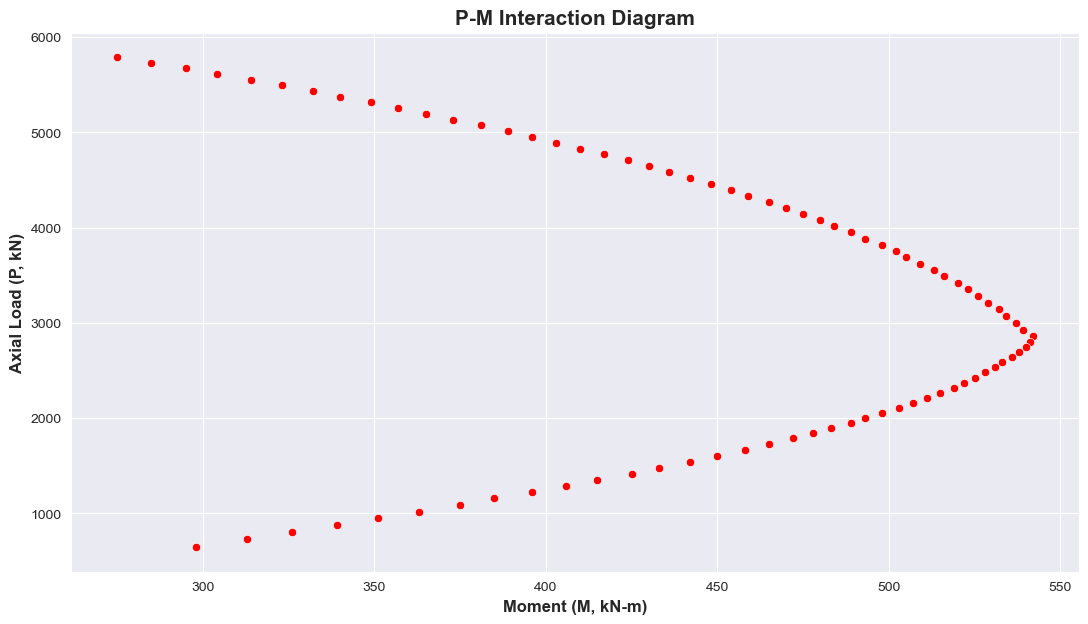

In [30]:
# Plotting the P-M Interaction Diagram

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize = (13,7))
plt.rc('axes', labelweight='bold', labelsize='large', titleweight ='bold',titlesize=15)
ax = sns.scatterplot(x=nom_moment,y=nom_load ,color='r')
# ax = sns.lineplot(x=nom_moment,y=nom_load ,color='r')
# ax = sns.lineplot(x='Mn(kN-m)',y="Pn(KN)",data=df,color='r')

ax.set_xlabel('Moment (M, kN-m)')
ax.set_ylabel('Axial Load (P, kN)')
plt.title('P-M Interaction Diagram')
plt.show()